In [1]:
import torch
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
from sklearn.model_selection import train_test_split, StratifiedKFold
import pandas as pd
import numpy as np
import random
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem import WordNetLemmatizer
import re
import matplotlib.pyplot as plt

# kaggle wordnet error fix
import nltk
import subprocess
try:
    nltk.data.find('wordnet.zip')
except:
    nltk.download('wordnet', download_dir='/kaggle/working/')
    command = "unzip -u /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"
    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

2024-02-28 10:48:43.603864: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-28 10:48:43.604011: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-28 10:48:43.793039: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  
  inflating: /kaggle/working/corpora/wordnet/verb.exc  
  inflating: /kaggle/working/corpora/wordnet/README  
  inflating: /kaggle/working/corpora/wordnet/index.sense  
  inflating: /kaggle/working/corpora/wordnet/data.

In [2]:
class CFG:
    seed = 42
    model_name = "distilbert-base-uncased"
    num_labels = None  # Number of labels/topics
    max_length = 512
    debug = False
    n_epochs = 3
    max_steps = -1
    batch_size = 16
    learning_rate = 2e-5
    warmup_steps = 500
    weight_decay = 0.01
    logging_steps = 100
    save_steps = 100
    evaluation_strategy = "steps"
    load_best_model_at_end = True
    report_to = "none"
    device ="cuda" if torch.cuda.is_available() else "cpu"
    if debug:
        max_steps=100

In [3]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [4]:
def get_data(train_size=0.65, valid_size=0.15):
    dataset = pd.read_csv('/kaggle/input/twitter-and-reddit/reddit_data.csv').dropna()
    if CFG.debug:
        dataset = dataset.sample(frac=0.10)
    
    documents = dataset['text'].tolist()
    mapping = {'pcmasterrace': 0, 'news': 1, 'relationships': 2, 'nfl': 3, 'movies': 4}
    labels = dataset['topic'].map(mapping).tolist()
    CFG.num_labels = dataset["topic"].nunique()
    
    # Split the dataset into train, validation, and test sets
    train_texts, test_texts, train_labels, test_labels = train_test_split(documents, labels, test_size=1-train_size, random_state=42)
    valid_texts, test_texts, valid_labels, test_labels = train_test_split(test_texts, test_labels, test_size=valid_size/(1-train_size), random_state=42)
    return (train_texts, valid_texts, test_texts, train_labels, valid_labels, test_labels), dataset.topic.unique()

In [5]:
def preprocess_text(text):
    REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;]')    # add/remove regex as required
    SYMBOLS_RE = re.compile('[^0-9a-z #+_]') # unnecessary symbols
    NUMBERS = re.compile('\d+') # numbers
    STOPWORDS = set(stopwords.words('english')) # stopwords
    stemmer = SnowballStemmer("english")  # Stemmer initialization
    lemmatizer = WordNetLemmatizer()  # lemmatizer

    # normalize and clean
    text = text.lower() # lowering the text
    text = REPLACE_BY_SPACE_RE.sub(' ', text) # removing punc
    text = SYMBOLS_RE.sub('', text) # removing unnecessary symbols
    text = NUMBERS.sub('', text) # removing stop words

    # remove stopwords
    tokens = [word for word in text.split() if word not in STOPWORDS]
    
    # stem tokens
    #tokens = [stemmer.stem(word) for word in tokens]
    
    # lemmatize tokens
    tokens = [lemmatizer.lemmatize(token) for token in tokens]
    
    return ' '.join(tokens)

In [6]:
def tokenize_data(tokenizer, texts):
    encodings = tokenizer(texts, truncation=True, padding=True, max_length=CFG.max_length)
    return encodings

In [7]:
def create_dataset(encodings, labels):
    class RedditDataset(torch.utils.data.Dataset):
        def __init__(self, encodings, labels):
            self.encodings = encodings
            self.labels = labels

        def __getitem__(self, idx):
            item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
            item['labels'] = torch.tensor(self.labels[idx])
            return item

        def __len__(self):
            return len(self.labels)

    return RedditDataset(encodings, labels)

In [8]:
def train_model(model, train_dataset, valid_dataset):
    # Create Trainer
    training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=CFG.n_epochs,
    per_device_train_batch_size=CFG.batch_size,
    per_device_eval_batch_size=CFG.batch_size,
    warmup_steps=CFG.warmup_steps,
    weight_decay=CFG.weight_decay,
    logging_steps=CFG.logging_steps,
    save_steps=CFG.save_steps,
    evaluation_strategy=CFG.evaluation_strategy,
    load_best_model_at_end=CFG.load_best_model_at_end,
    report_to= CFG.report_to,
    max_steps=CFG.max_steps
    )
    
    trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=valid_dataset,
    )
    
    # Train and Save
    trainer.train()
    trainer.save_model()
    
    eval_result = trainer.evaluate()
    print("Evaluation result:", eval_result)
    plot_loss_curves(trainer)
        
    return trainer    

In [9]:
def test_model(trainer, test_dataset):
    eval_result = trainer.evaluate(test_dataset)
    print("Test set evaluation result:", eval_result)
    plot_confusion_matrix(trainer, test_dataset)

In [10]:
def predict_from_test_set(trainer, test_dataset, tokenizer, num_samples=5):
    # Sample some sentences from the test set
    sample_indices = np.random.choice(len(test_dataset), num_samples, replace=False)
    sampled_data = [test_dataset[i] for i in sample_indices]

    # Iterate over the sampled data and make predictions
    for data in sampled_data:
        inputs = {k: v.clone().detach().unsqueeze(0).to(CFG.device) for k, v in data.items()}
        outputs = trainer.model(**inputs)  # Use trainer.model instead of model
        probs = outputs.logits.softmax(1)
        predicted_class = probs.argmax().item()
        
        # Display the sample text, ground truth, and prediction
        print("Text:", tokenizer.decode(inputs["input_ids"][0], skip_special_tokens=True))
        print("Ground Truth:", data["labels"].item())
        print("Predicted Class:", predicted_class)
        print("=" * 50)

In [11]:
def compute_metrics(pred):
    preds = pred.predictions.argmax(-1)
    acc = accuracy_score(pred.label_ids, preds)
    f1 = f1_score(pred.label_ids, preds, average='macro')
    return {'accuracy': acc, 'f1_macro': f1}

In [12]:
def plot_loss_curves(trainer):
    train_loss = [item['loss'] for item in trainer.state.log_history if 'loss' in item]
    val_loss = [item['eval_loss'] for item in trainer.state.log_history if 'eval_loss' in item]
    plt.plot(train_loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Loss Curves')
    plt.legend()
    plt.show()  
    plt.close()  

In [13]:
def plot_confusion_matrix(trainer, test_dataset):
    preds = trainer.predict(test_dataset)
    pred_labels = np.argmax(preds.predictions, axis=1)
    true_labels = test_dataset.labels  
    cm = confusion_matrix(true_labels, pred_labels)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=range(CFG.num_labels))
    disp.plot(cmap=plt.cm.Blues, values_format='d')
    plt.title("Confusion Matrix (Test Dataset)")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.show()
    plt.close()  

In [14]:
def merge_datasets(train_dataset, valid_dataset):
    merged_encodings = {key: np.concatenate([train_dataset.encodings[key], valid_dataset.encodings[key]], axis=0) 
                        for key in train_dataset.encodings.keys()}
    merged_labels = np.concatenate([train_dataset.labels, valid_dataset.labels], axis=0)
    return create_dataset(merged_encodings, merged_labels)

def perform_cross_validation(model, merged_dataset, n_splits=5):
    skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=CFG.seed)
    fold_accuracies = []
    
    for fold, (train_idx, val_idx) in enumerate(skf.split(merged_dataset.encodings['input_ids'], merged_dataset.labels)):
        print("=" * 50)
        print(f"Fold {fold+1}/{n_splits}")
        train_encodings_fold = {key: merged_dataset.encodings[key][train_idx] for key in merged_dataset.encodings.keys()}
        train_labels_fold = merged_dataset.labels[train_idx]
        valid_encodings_fold = {key: merged_dataset.encodings[key][val_idx] for key in merged_dataset.encodings.keys()}
        valid_labels_fold = merged_dataset.labels[val_idx]
        
        train_fold_dataset = create_dataset(train_encodings_fold, train_labels_fold)
        valid_fold_dataset = create_dataset(valid_encodings_fold, valid_labels_fold)
        
        # Train model on this fold
        trainer = train_model(model, train_fold_dataset, valid_fold_dataset)
        
        # Evaluate on validation set
        eval_result = trainer.evaluate(valid_fold_dataset)
        fold_accuracy = eval_result['eval_accuracy']
        print(f"Accuracy on validation set for fold {fold+1}: {fold_accuracy}\n")
        fold_accuracies.append(fold_accuracy)
    
    avg_accuracy = sum(fold_accuracies) / len(fold_accuracies)
    print(f"Average accuracy over {n_splits} folds: {avg_accuracy}")

In [15]:
set_seed(CFG.seed)

In [16]:
# Get data

(train_texts, valid_texts, test_texts, train_labels, valid_labels, test_labels), target_names = get_data()

train_texts[100], valid_texts[100], test_texts[100], train_labels[100], valid_labels[100], test_labels[100], target_names

("Sorry if i'm calling it slow but I'm a very impatient person who doesn't like to wait. ",
 "14th isn't especially good, either, considering how many chances that Peyton has had.  The two players that OP compared him to are number 3 and 4 in passer rating and the difference is over 10 points.  Peyton is closer in rating to #32 than he is to #4 ...and he's behind Rodgers, Brees, Wilson, *Sanchez*, Romo, Eli, Brady, and Flacco...\n\n\nSo 8 of the 13 in front of him are contemporaries. \n\n\n ",
 'Soooo... These people are getting rich for making a crappy game.... ',
 0,
 3,
 0,
 array(['pcmasterrace', 'news', 'movies', 'nfl', 'relationships'],
       dtype=object))

In [17]:
# Preprocess text

train_texts = [preprocess_text(text) for text in train_texts]
valid_texts = [preprocess_text(text) for text in valid_texts]
test_texts = [preprocess_text(text) for text in test_texts]

train_texts[100], valid_texts[100], test_texts[100]

('sorry im calling slow im impatient person doesnt like wait',
 'th isnt especially good either considering many chance peyton two player op compared number passer rating difference point peyton closer rating # # he behind rodgers brees wilson sanchez romo eli brady flaccoso front contemporary',
 'soooo people getting rich making crappy game')

In [18]:
# Tokenize data
tokenizer = DistilBertTokenizerFast.from_pretrained(CFG.model_name)
train_encodings = tokenize_data(tokenizer, train_texts)
valid_encodings = tokenize_data(tokenizer, valid_texts)
test_encodings = tokenize_data(tokenizer, test_texts)

print(tokenizer.convert_ids_to_tokens(train_encodings["input_ids"][100]))

tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

['[CLS]', 'sorry', 'im', 'calling', 'slow', 'im', 'impatient', 'person', 'doesn', '##t', 'like', 'wait', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PA

In [19]:
# Create datasets
train_dataset = create_dataset(train_encodings, train_labels)
valid_dataset = create_dataset(valid_encodings, valid_labels)
test_dataset = create_dataset(test_encodings, test_labels)

# Print lengths and total
print(f"Length of train_dataset: {len(train_dataset)}")
print(f"Length of valid_dataset: {len(valid_dataset)}")
print(f"Length of test_dataset: {len(test_dataset)}")
print(f"Total number of samples: {len(train_dataset) + len(valid_dataset) + len(test_dataset)}")

Length of train_dataset: 24989
Length of valid_dataset: 7689
Length of test_dataset: 5768
Total number of samples: 38446


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,1.541000,1.309524,0.539082,0.401911
200,1.048100,0.820924,0.714007,0.709785
300,0.829700,0.779693,0.711666,0.705054
400,0.795800,0.764427,0.720250,0.714080
500,0.794100,0.718749,0.732215,0.727334
600,0.742600,0.706969,0.735076,0.733201
700,0.728900,0.703712,0.742099,0.738916
800,0.689900,0.717550,0.736897,0.734000
900,0.601500,0.710903,0.742749,0.738773
1000,0.591000,0.693977,0.748992,0.743471


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead u

Evaluation result: {'eval_loss': 0.6755310893058777, 'eval_accuracy': 0.7534139680062427, 'eval_f1_macro': 0.7507268408595558, 'eval_runtime': 70.3719, 'eval_samples_per_second': 109.262, 'eval_steps_per_second': 3.425, 'epoch': 3.0}


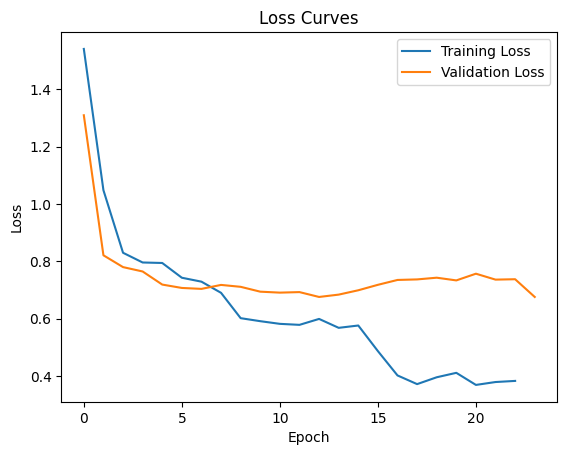

In [20]:
# Train model
model = DistilBertForSequenceClassification.from_pretrained(CFG.model_name, num_labels=CFG.num_labels).to(CFG.device)    
trainer = train_model(model, train_dataset, valid_dataset)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Test set evaluation result: {'eval_loss': 0.6777671575546265, 'eval_accuracy': 0.7506934812760055, 'eval_f1_macro': 0.747787971886277, 'eval_runtime': 52.7765, 'eval_samples_per_second': 109.291, 'eval_steps_per_second': 3.43, 'epoch': 3.0}


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


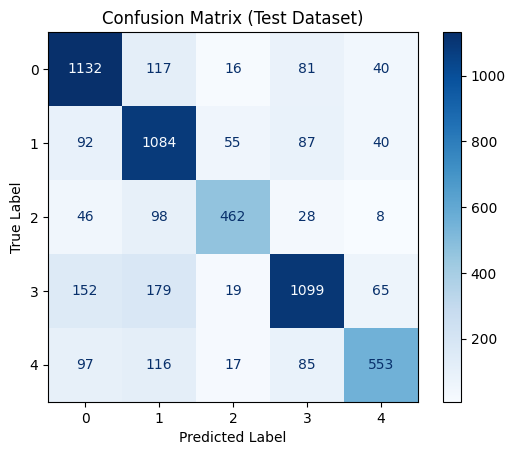

In [21]:
# Test model
test_model(trainer, test_dataset)

In [22]:
# Predict from random test data
predict_from_test_set(trainer, test_dataset, tokenizer, num_samples=5)

Text: happen point maybe day finally arrived hopefully see guess depends long take go trail man hasnt even hearing merit much le trial merely charged respect notion innocent proven guilty expect applied criminal defendant expect criminal defendant get treatmentwhy wont people let fact talking maybe let see fair trial
Ground Truth: 1
Predicted Class: 1
Text: dont know feel like sack total taken collectively help much attention receive individuallyi mean wilk alone theyre good together theyre force harrison usually commanding lot attention freeing others
Ground Truth: 3
Predicted Class: 3
Text: gold gift sir would getting http iimgurcom kskiyogif dont understand people think amd card hot http wwwtomshardwarecom review radeonrxthirdpartyroundup html look temperature high mid full load okay
Ground Truth: 0
Predicted Class: 0
Text: choose live america respect right others one forcing people go event two shithead couldve like rest islamic community simply ignored sacrificing right others may

Fold 1/5


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,0.509200,0.485533,0.827264,0.823970
200,0.511800,0.479428,0.825734,0.824393
300,0.526000,0.479492,0.828335,0.824569
400,0.505500,0.490539,0.824969,0.823365
500,0.554100,0.505071,0.813341,0.810833
600,0.548000,0.506754,0.817931,0.815813
700,0.529900,0.507663,0.819767,0.815617
800,0.561600,0.513794,0.815330,0.811812
900,0.430200,0.527906,0.822215,0.819810
1000,0.394300,0.528765,0.811353,0.807495


Checkpoint destination directory ./results/checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/pytho

Evaluation result: {'eval_loss': 0.4794284701347351, 'eval_accuracy': 0.825734394124847, 'eval_f1_macro': 0.8243927404944038, 'eval_runtime': 58.6894, 'eval_samples_per_second': 111.366, 'eval_steps_per_second': 3.493, 'epoch': 3.0}


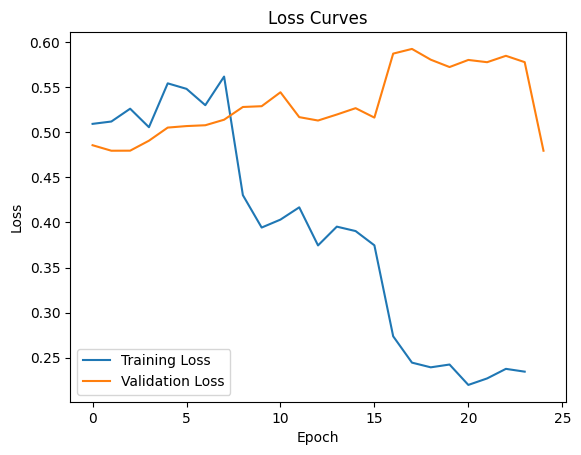

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy on validation set for fold 1: 0.825734394124847

Fold 2/5


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,0.489100,0.457855,0.835526,0.834024
200,0.483100,0.459656,0.831548,0.830078
300,0.512100,0.467341,0.828794,0.826823
400,0.513300,0.493479,0.824663,0.820397
500,0.536200,0.495860,0.825581,0.823391
600,0.505300,0.493730,0.816554,0.813034
700,0.521300,0.502591,0.818237,0.815852
800,0.544700,0.494760,0.819308,0.816658
900,0.407800,0.510511,0.820073,0.816845
1000,0.369900,0.539230,0.813800,0.812410


Checkpoint destination directory ./results/checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/pytho

Evaluation result: {'eval_loss': 0.45785513520240784, 'eval_accuracy': 0.8355263157894737, 'eval_f1_macro': 0.8340238571294869, 'eval_runtime': 58.3508, 'eval_samples_per_second': 112.012, 'eval_steps_per_second': 3.513, 'epoch': 3.0}


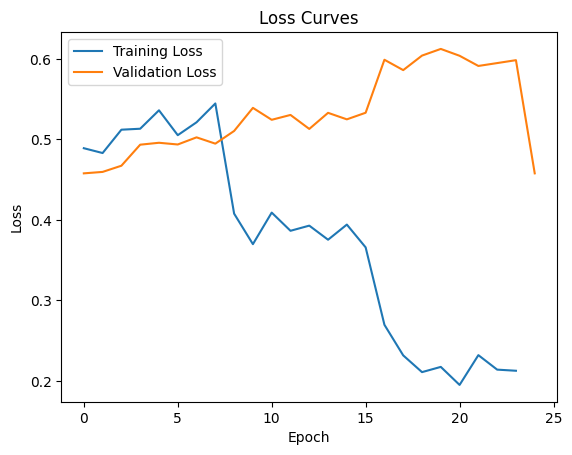

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy on validation set for fold 2: 0.8355263157894737

Fold 3/5


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,0.506700,0.436335,0.846542,0.846864
200,0.509900,0.444088,0.842105,0.840915
300,0.510600,0.450671,0.840728,0.840231
400,0.498300,0.466366,0.830171,0.830003
500,0.521900,0.522425,0.811200,0.804589
600,0.536700,0.501399,0.820226,0.818792
700,0.535900,0.519622,0.811353,0.809026
800,0.506500,0.504420,0.821144,0.817248
900,0.393500,0.506132,0.826346,0.823901
1000,0.379500,0.537954,0.817778,0.817699


Checkpoint destination directory ./results/checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/pytho

Evaluation result: {'eval_loss': 0.4363348186016083, 'eval_accuracy': 0.8465422276621787, 'eval_f1_macro': 0.8468641386484098, 'eval_runtime': 58.8854, 'eval_samples_per_second': 110.995, 'eval_steps_per_second': 3.481, 'epoch': 3.0}


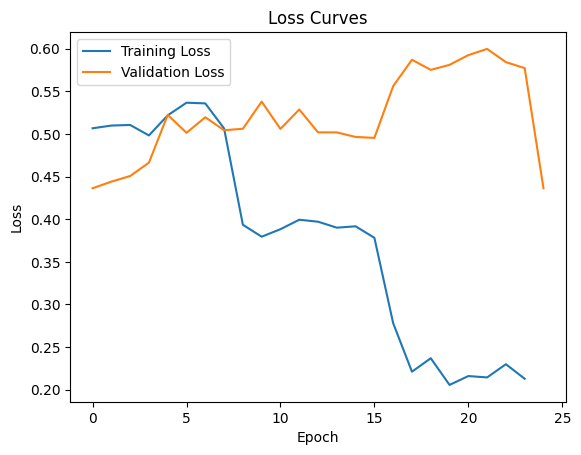

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy on validation set for fold 3: 0.8465422276621787

Fold 4/5


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,0.451600,0.457987,0.842234,0.841205
200,0.471000,0.464250,0.839786,0.837475
300,0.496000,0.483311,0.828768,0.825862
400,0.512500,0.521940,0.813619,0.807155
500,0.523000,0.481648,0.828921,0.826323
600,0.518300,0.509473,0.815149,0.811108
700,0.519100,0.507739,0.819893,0.815708
800,0.530900,0.508085,0.820811,0.819651
900,0.394700,0.525311,0.826932,0.824456
1000,0.380300,0.551531,0.821882,0.819078


Checkpoint destination directory ./results/checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/pytho

Evaluation result: {'eval_loss': 0.4579867124557495, 'eval_accuracy': 0.8422341239479725, 'eval_f1_macro': 0.8412046338925447, 'eval_runtime': 58.9676, 'eval_samples_per_second': 110.824, 'eval_steps_per_second': 3.476, 'epoch': 3.0}


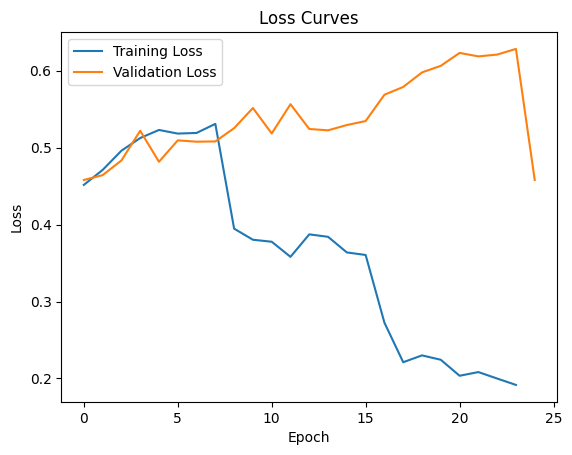

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy on validation set for fold 4: 0.8422341239479725

Fold 5/5


/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Step,Training Loss,Validation Loss,Accuracy,F1 Macro
100,0.452600,0.450794,0.839174,0.837536
200,0.470200,0.466270,0.832747,0.831326
300,0.490000,0.459586,0.831370,0.831365
400,0.509900,0.486499,0.821423,0.818250
500,0.504300,0.514454,0.815149,0.814451
600,0.516500,0.526080,0.810406,0.812370
700,0.542100,0.510111,0.813007,0.812748
800,0.575500,0.496064,0.818822,0.816765
900,0.400900,0.520826,0.822188,0.820340
1000,0.393900,0.508549,0.817904,0.818944


Checkpoint destination directory ./results/checkpoint-100 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-200 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
Checkpoint destination directory ./results/checkpoint-300 already exists and is non-empty.Saving will proceed but saved results may be invalid.
/opt/conda/lib/pytho

Evaluation result: {'eval_loss': 0.45079419016838074, 'eval_accuracy': 0.8391736801836266, 'eval_f1_macro': 0.8375360555401461, 'eval_runtime': 58.9078, 'eval_samples_per_second': 110.936, 'eval_steps_per_second': 3.48, 'epoch': 3.0}


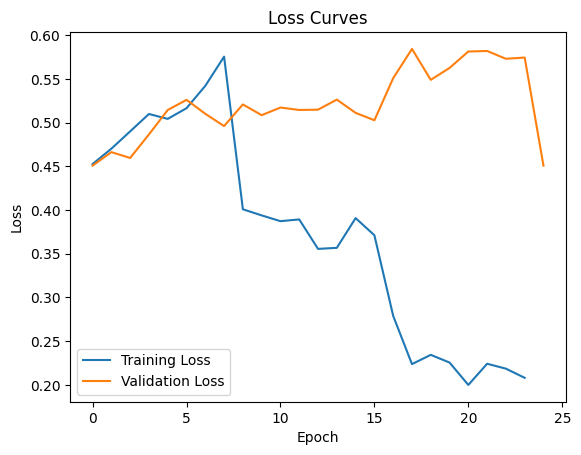

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Accuracy on validation set for fold 5: 0.8391736801836266

Average accuracy over 5 folds: 0.8378421483416197


In [23]:
# Perform 5-fold cross-validation
merged_dataset = merge_datasets(train_dataset, valid_dataset)
perform_cross_validation(model, merged_dataset, n_splits=5)

In [24]:
# set_seed(CFG.seed)
# # Get data
# (train_texts, valid_texts, test_texts, train_labels, valid_labels, test_labels), target_names = get_data()
# # Preprocess text
# train_texts = [preprocess_text(text) for text in train_texts]
# valid_texts = [preprocess_text(text) for text in valid_texts]
# test_texts = [preprocess_text(text) for text in test_texts]
# # Tokenize data
# tokenizer = DistilBertTokenizerFast.from_pretrained(CFG.model_name)
# train_encodings = tokenize_data(tokenizer, train_texts)
# valid_encodings = tokenize_data(tokenizer, valid_texts)
# test_encodings = tokenize_data(tokenizer, test_texts)
# # Create datasets
# train_dataset = create_dataset(train_encodings, train_labels)
# valid_dataset = create_dataset(valid_encodings, valid_labels)
# test_dataset = create_dataset(test_encodings, test_labels)
# # Train model
# model = DistilBertForSequenceClassification.from_pretrained(CFG.model_name, num_labels=CFG.num_labels).to(CFG.device)    
# trainer = train_model(model, train_dataset, valid_dataset)
# # Test model
# test_model(trainer, test_dataset)
# # Predict from random test data
# predict_from_test_set(trainer, test_dataset, tokenizer, num_samples=5)
# # Perform 5-fold cross-validation
# merged_dataset = merge_datasets(train_dataset, valid_dataset)
# perform_cross_validation(model, merged_dataset, n_splits=5)